In [42]:
import segmentation_models_pytorch as smp

model_1 = smp.Unet(
    encoder_name = "resnet34",
    encoder_weights = "imagenet",
    in_channels = 1,
    classes = 3,

)

model_2 = smp.UnetPlusPlus(
    encoder_name = "resnet34",
    encoder_weights = "imagenet",
    in_channels= 1,
    classes= 3,

)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import cv2
import matplotlib.pyplot as plt

DATA_DIR = "./data/CamVid/"

if not os.path.exists(DATA_DIR):
    print("Loading data......")
    os.system("git clone https://github.com/alexgkendall/SegNet-Tutorial ./data")
    print("Done!")

x_train_dir = os.path.join(DATA_DIR, "train")
y_train_dir = os.path.join(DATA_DIR, "trainannot")

x_valid_dir = os.path.join(DATA_DIR, "val")
y_valid_dir = os.path.join(DATA_DIR, "valannot")

x_test_dir = os.path.join("DATA_DIR", "test")
y_test_dir = os.path.join("DATA_DIR", "testannot")

def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.title("".join(name.split("_")).title())
        plt.imshow(image)
    plt.show()

In [43]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [67]:
class Dataset(BaseDataset):

    CLASSES = ["sky", "building", "pole", "road", "pavement", "tree", "signsymbol",
    "fence", "car", "pedestrian", "bicyclist", "unlabelled"]

    def __init__(
        self,
        images_dir,
        masks_dir,
        classes = None,
        augmentation = None,
        preprocessing = None,):

        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        #データの読み込み
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        #マスクから正確なくらすを抽出
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis = -1).astype("float")

        #データの水増しを適用
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]
        #preprocessingを適用
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]
        
        return image, mask
    
    def __len__(self):
        return len(self.ids)

TypeError: Invalid shape (360, 480, 2) for image data

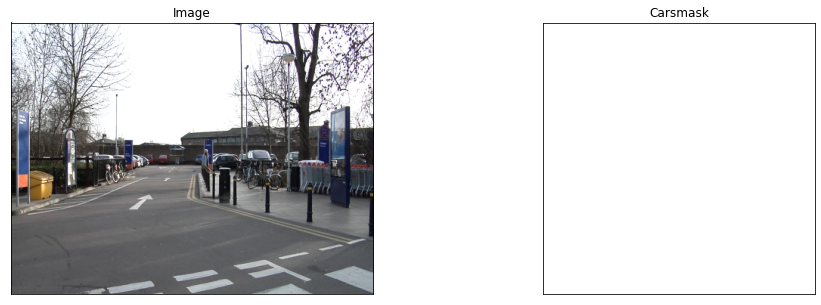

In [78]:
dataset = Dataset(x_train_dir, y_train_dir, classes= ["road","car"])

image, mask = dataset[12]
visualize(
    image=image,
    cars_mask = mask.squeeze(),
)